In [2]:
import modern_robotics as mr
import sympy as sp
from sympy import*
from sympy.physics.mechanics import dynamicsymbols, mechanics_printing
mechanics_printing()

In [5]:
def exp3(omega, theta):
    omega = skew(omega)
    R = sp.eye(3) + sp.sin(theta) * omega + (1 - sp.cos(theta)) * omega * omega
    return R

def skew(v):
    return Matrix([[0, -v[2], v[1]],
                    [v[2], 0, -v[0]],
                    [-v[1], v[0], 0]])
                    
def exp6(twist, theta):
    omega = skew(twist[:3])
    v = Matrix(twist[3:])
    T = eye(4)
    T[:3,:3] = exp3(twist[:3], theta)
    T[:3,3] = (eye(3) * theta + (1 - cos(theta)) * omega +
              (theta-sin(theta)) * omega * omega) * v
    return T



def Ad(T):
    AdT = sp.zeros(6)
    R = sp.Matrix(T[:3, :3])
    AdT[:3, :3] = R
    AdT[3:, 3:] = R
    AdT[3:, :3] = skew(T[:3, 3]) * R
    return AdT

def rotX(alfa_im1):
    Rx = sp.eye(4)
    Rx[1,1] =    sp.cos(alfa_im1)
    Rx[1,2] =   -sp.sin(alfa_im1)
    Rx[2,1] =    sp.sin(alfa_im1)
    Rx[2,2] =    sp.cos(alfa_im1)
    return Rx

def rotZ(alfa_im1):
    Rz = sp.eye(4)
    Rz[0,0] =    sp.cos(alfa_im1)
    Rz[0,1] =   -sp.sin(alfa_im1)
    Rz[1,0] =    sp.sin(alfa_im1)
    Rz[1,1] =    sp.cos(alfa_im1)
    return Rz

def transX(a_im1):
    trA = sp.eye(4)
    trA[0,3] =  a_im1
    return trA

def transZ(d_i):
    trA = sp.eye(4)
    trA[2,3] =  d_i
    return trA


Task 1:


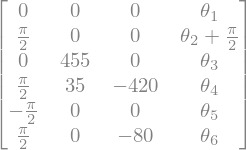

In [6]:
# Oppg 1
print("Task 1:")

th1, th2, th3, th4, th5, th6 = dynamicsymbols('theta_1, theta_2, theta_3, theta_4, theta_5, theta_6')

config = sp.Matrix([[0,0,0,th1],[sp.pi/2,0,0,th2 + sp.pi/2],[0,455,0,th3],[sp.pi/2, 35, -420, th4],[-sp.pi/2,0,0,th5],[sp.pi/2, 0, -80,th6]])
config

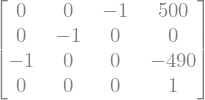

In [7]:
# oppg 2
Mi = sp.Matrix([[sp.eye(4)]*6])

for i in range(6):
    if i == 1:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2]) * rotZ(-sp.pi/2) # We compansate for the rotation of -pi/2 done when finding the D-H parameters 
    else:
        Mi[:,4*i:4*(i+1)] = rotX(config[i,0]) * transX(config[i,1]) * transZ(config[i,2])

M = sp.eye(4)
for n in range(5,-1,-1):
    M = Mi[:,4*n:4*(n+1)] * M


M 

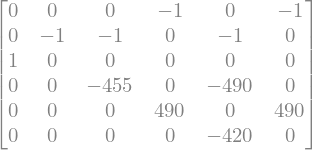

In [8]:
# oppg 3
Ai = sp.Matrix([[0,-1,0,0],[1,0,0,0],[0,0,0,0],[0,0,0,0]]) # This is a given matrix due to revolute joints

S_sp = sp.zeros(6)
for i in range(6):
    dot_sum = sp.eye(4)
    for n in range(i,-1,-1):
        dot_sum = Mi[:,4*n:4*(n+1)] * dot_sum
    S_skew = dot_sum * Ai * sp.Inverse(dot_sum)
    S_sp[0,i] = S_skew[2,1] 
    S_sp[1,i] = S_skew[0,2] 
    S_sp[2,i] = S_skew[1,0] 
    S_sp[3,i] = S_skew[0,3] 
    S_sp[4,i] = S_skew[1,3] 
    S_sp[5,i] = S_skew[2,3] 

S_sp

In [15]:
# oppg 4, find body frame screw axis, S_bp

M_inv = mr.TransInv(M)          #Finding inverse of M
Ad_M_inv = mr.Adjoint(M_inv)    #Computing [Ad_M^-1]

#Using B_i = [Ad_M^-1]S_i
S_bp = sp.zeros(6,6)
for i in range(6):
     S_bp[:, i] = Ad_M_inv * S_sp[:, i]

S_bp

⎡ -1    0     0    0   0   0⎤
⎢                           ⎥
⎢ 0     1     1    0   1   0⎥
⎢                           ⎥
⎢ 0     0     0    1   0   1⎥
⎢                           ⎥
⎢ 0    -500  -500  0  -80  0⎥
⎢                           ⎥
⎢-500   0     0    0   0   0⎥
⎢                           ⎥
⎣ 0    -490  -35   0   0   0⎦